In [1]:
# decision_tree.py
# ---------
# Licensing Information:  You are free to use or extend these projects for
# personal and educational purposes provided that (1) you do not distribute
# or publish solutions, (2) you retain this notice, and (3) you provide clear
# attribution to UT Dallas, including a link to http://cs.utdallas.edu.
#
# This file is part of Homework for CS6375: Machine Learning.
# Gautam Kunapuli (gautam.kunapuli@utdallas.edu)
# Sriraam Natarajan (sriraam.natarajan@utdallas.edu),
# Anjum Chida (anjum.chida@utdallas.edu)
#
#
# INSTRUCTIONS:
# ------------
# 1. This file contains a skeleton for implementing the ID3 algorithm for
# Decision Trees. Insert your code into the various functions that have the
# comment "INSERT YOUR CODE HERE".
#
# 2. Do NOT modify the classes or functions that have the comment "DO NOT
# MODIFY THIS FUNCTION".
#
# 3. Do not modify the function headers for ANY of the functions.
#
# 4. You may add any other helper functions you feel you may need to print,
# visualize, test, or save the data and results. However, you MAY NOT utilize
# the package scikit-learn OR ANY OTHER machine learning package in THIS file.

import numpy as np
import os
import graphviz

In [2]:
from collections import defaultdict

def partition(x):
    """
    Partition the column vector x into subsets indexed by its unique values (v1, ... vk)

    Returns a dictionary of the form
    { v1: indices of x == v1,
      v2: indices of x == v2,
      ...
      vk: indices of x == vk }, where [v1, ... vk] are all the unique values in the vector z.
    """

    # INSERT YOUR CODE HERE
    Dict = defaultdict(list)
    index=0
    for i in x:
        if i in Dict:
            Dict[i].append(index)
        else:
            Dict.setdefault(i,[]).append(index)
        index+=1
    
    return Dict        
    raise Exception('Function not yet implemented!')
    
# #DEBUG
# x = np.array([1,2,3,3]) 
# partition(x)

In [3]:
def entropy(y):
    """
    Compute the entropy of a vector y by considering the counts of the unique values (v1, ... vk), in z

    Returns the entropy of z: H(z) = p(z=v1) log2(p(z=v1)) + ... + p(z=vk) log2(p(z=vk))
    """

    # INSERT YOUR CODE HERE
    n = len(y)
    
    unique_freq = np.bincount(y)
    p = unique_freq[np.nonzero(unique_freq)] / n
    
    return - np.sum(p * np.log2(p))

    raise Exception('Function not yet implemented!')

#DEBUG
#x = np.array([1,2,1,2]) 
#entropy(x)

In [4]:
def mutual_information(x, y):
    """
    Compute the mutual information between a data column (x) and the labels (y). The data column is a single attribute
    over all the examples (n x 1). Mutual information is the difference between the entropy BEFORE the split set, and
    the weighted-average entropy of EACH possible split.

    Returns the mutual information: I(x, y) = H(y) - H(y | x)
    """
    x=np.asarray(x)
    y=np.asarray(y)
    
    val = partition(x)
    
    H_y = entropy(y)
    H_xy = 0
    length=len(x)
    
    for key in val:
        p=len(val[key])/length
        p=p*entropy(y.take(val[key],axis=0))
        H_xy=H_xy+p
        
    I_xy= H_y-H_xy
    
    return I_xy

In [5]:
def create_att_val_pairs(x):
    attribute_value_pairs=[]
    col_num=0
    
    for column in x.T:
        for x in set(column):
            attribute_value_pairs.append(tuple((col_num,x)))
        col_num+=1
    return attribute_value_pairs

In [6]:
def id3(x, y, attribute_value_pairs=None, depth=0, max_depth=5):
    """
    Implements the classical ID3 algorithm given training data (x), training labels (y) and an array of
    attribute-value pairs to consider. This is a recursive algorithm that depends on three termination conditions
        1. If the entire set of labels (y) is pure (all y = only 0 or only 1), then return that label
        2. If the set of attribute-value pairs is empty (there is nothing to split on), then return the most common
           value of y (majority label)
        3. If the max_depth is reached (pre-pruning bias), then return the most common value of y (majority label)
    Otherwise the algorithm selects the next best attribute-value pair using INFORMATION GAIN as the splitting criterion
    and partitions the data set based on the values of that attribute before the next recursive call to ID3.

    The tree we learn is a BINARY tree, which means that every node has only two branches. The splitting criterion has
    to be chosen from among all possible attribute-value pairs. That is, for a problem with two features/attributes x1
    (taking values a, b, c) and x2 (taking values d, e), the initial attribute value pair list is a list of all pairs of
    attributes with their corresponding values:
    [(x1, a),
     (x1, b),
     (x1, c),
     (x2, d),
     (x2, e)]
     If we select (x2, d) as the best attribute-value pair, then the new decision node becomes: [ (x2 == d)? ] and
     the attribute-value pair (x2, d) is removed from the list of attribute_value_pairs.

    The tree is stored as a nested dictionary, where each entry is of the form
                    (attribute_index, attribute_value, True/False): subtree
    * The (attribute_index, attribute_value) determines the splitting criterion of the current node. For example, (4, 2)
    indicates that we test if (x4 == 2) at the current node.
    * The subtree itself can be nested dictionary, or a single label (leaf node).
    * Leaf nodes are (majority) class labels

    Returns a decision tree represented as a nested dictionary, for example
    {(4, 1, False):
        {(0, 1, False):
            {(1, 1, False): 1,
             (1, 1, True): 0},
         (0, 1, True):
            {(1, 1, False): 0,
             (1, 1, True): 1}},
     (4, 1, True): 1}
    """
    if attribute_value_pairs == None :
        attribute_value_pairs = create_att_val_pairs(x)
    if(len(y)==0):
        return
        
        #If y is pure; return y
    if(len(set(y))==1):
        return y[0]

        #If set of all att_val pairs is empty or OR max depth has been reached; return majority class
    if len(attribute_value_pairs) == 0 or depth == max_depth :
        val= np.argmax(np.bincount(np.array(y)))
        return val
    
    else :
        val_max = 0
        for k,v in attribute_value_pairs:
            x_k=np.asarray(x)
            tmp = x_k[:,k].tolist()
            length=len(x)
            for i in range(0, length):
                if tmp[i]!=v:
                    tmp[i]=0
            val = mutual_information(tmp,y)
            if val >= val_max:
                val_max = val
                (k_max,v_max) = (k,v)

        x_kmax=np.asarray(x)
        
        final =partition(x_kmax[:,k_max].tolist())[v_max]        
        
        xt = []
        xf = []
        yt = []
        yf = []
        
        for i in range(0, len(x)):
            temp = np.asarray(x[i])
            if i in final:
                xt.append(temp)
                yt.append(y[i])
            else:
                xf.append(temp)
                yf.append(y[i])
        
            #Remove from the attribute list 
        attribute_value_pairs_new=attribute_value_pairs.copy()
        attribute_value_pairs_new.remove((k_max,v_max))
        
        depth+=1
        tree=dict()
        tree.update({(k_max,v_max, True): id3(xt, yt, attribute_value_pairs_new, depth, max_depth)})
        tree.update({(k_max,v_max, False): id3(xf, yf, attribute_value_pairs_new, depth, max_depth)})
        return tree
# #DEBUG
# x1 = [0, 1, 1, 2, 2, 2]
# x2 = [0, 0, 1, 1, 1, 0]
# y = np.array([0, 0, 0, 1, 1, 0]) 
# X = np.array([x1, x2]).T
# print(id3(X, y))

In [7]:
def predict_example(x, tree):
    """
    Predicts the classification label for a single example x using tree by recursively descending the tree until
    a label/leaf node is reached.

    Returns the predicted label of x according to tree
    """
    
    try:
        len(tree.keys())
        
    except Exception:
        return tree
    
    k=tree.keys()
    v = list(k)[0]
    
    if (x[v[0]] == v[1]):
        return predict_example(x, tree[(v[0],v[1], True)])
    else:
        return predict_example(x, tree[(v[0],v[1], False)])


In [8]:
def compute_error(y_true, y_pred):
    """
    Computes the average error between the true labels (y_true) and the predicted labels (y_pred)

    Returns the error = (1/n) * sum(y_true != y_pred)
    """
    count=0
    dif=np.asarray(y_true)-np.asarray(y_pred)
    for i in dif:
        if i!=0:
            count+=1
    return count/len(y_true)
    

In [9]:
def pretty_print(tree, depth=0):
    """
    Pretty prints the decision tree to the console. Use print(tree) to print the raw nested dictionary representation
    DO NOT MODIFY THIS FUNCTION!
    """
    if depth == 0:
        print('TREE')

    for index, split_criterion in enumerate(tree):
        sub_trees = tree[split_criterion]

        print('|\t' * depth, end='')
        print('+-- [SPLIT: x{0} = {1} {2}]'.format(split_criterion[0], split_criterion[1], split_criterion[2]))

        # Print the children
        if type(sub_trees) is dict:
            pretty_print(sub_trees, depth + 1)
        else:
            print('|\t' * (depth + 1), end='')
            print('+-- [LABEL = {0}]'.format(sub_trees))

In [10]:
def render_dot_file(dot_string, save_file, image_format='png'):
    """
    Uses GraphViz to render a dot file. The dot file can be generated using
        * sklearn.tree.export_graphviz()' for decision trees produced by scikit-learn
        * to_graphviz() (function is in this file) for decision trees produced by  your code.
    DO NOT MODIFY THIS FUNCTION!
    """
    if type(dot_string).__name__ != 'str':
        raise TypeError('visualize() requires a string representation of a decision tree.\nUse tree.export_graphviz()'
                        'for decision trees produced by scikit-learn and to_graphviz() for decision trees produced by'
                        'your code.\n')

    # Set path to your GraphViz executable here
    os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
    graph = graphviz.Source(dot_string)
    graph.format = image_format
    graph.render(save_file, view=True)

In [11]:
def to_graphviz(tree, dot_string='', uid=-1, depth=0):
    """
    Converts a tree to DOT format for use with visualize/GraphViz
    DO NOT MODIFY THIS FUNCTION!
    """

    uid += 1       # Running index of node ids across recursion
    node_id = uid  # Node id of this node

    if depth == 0:
        dot_string += 'digraph TREE {\n'

    for split_criterion in tree:
        sub_trees = tree[split_criterion]
        attribute_index = split_criterion[0]
        attribute_value = split_criterion[1]
        split_decision = split_criterion[2]

        if not split_decision:
            # Alphabetically, False comes first
            dot_string += '    node{0} [label="x{1} = {2}?"];\n'.format(node_id, attribute_index, attribute_value)

        if type(sub_trees) is dict:
            if not split_decision:
                dot_string, right_child, uid = to_graphviz(sub_trees, dot_string=dot_string, uid=uid, depth=depth + 1)
                dot_string += '    node{0} -> node{1} [label="False"];\n'.format(node_id, right_child)
            else:
                dot_string, left_child, uid = to_graphviz(sub_trees, dot_string=dot_string, uid=uid, depth=depth + 1)
                dot_string += '    node{0} -> node{1} [label="True"];\n'.format(node_id, left_child)

        else:
            uid += 1
            dot_string += '    node{0} [label="y = {1}"];\n'.format(uid, sub_trees)
            if not split_decision:
                dot_string += '    node{0} -> node{1} [label="False"];\n'.format(node_id, uid)
            else:
                dot_string += '    node{0} -> node{1} [label="True"];\n'.format(node_id, uid)

    if depth == 0:
        dot_string += '}\n'
        return dot_string
    else:
        return dot_string, node_id, uid

In [12]:
if __name__ == '__main__':
    # Load the training data
    M = np.genfromtxt('monks_data/monks-1.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
    ytrn = M[:, 0]
    Xtrn = M[:, 1:]

    # Load the test data
    M = np.genfromtxt('monks_data/monks-1.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
    ytst = M[:, 0]
    Xtst = M[:, 1:]

    # Learn a decision tree of depth 3
    decision_tree = id3(Xtrn, ytrn, max_depth=3)

    # Pretty print it to console
    pretty_print(decision_tree)

    # Visualize the tree and save it as a PNG image
    dot_str = to_graphviz(decision_tree)
    render_dot_file(dot_str, './my_learned_tree')

    # Compute the test error
    y_pred = [predict_example(x, decision_tree) for x in Xtst]
    tst_err = compute_error(ytst, y_pred)

    print('Test Error = {0:4.2f}%.'.format(tst_err * 100))
    

TREE
+-- [SPLIT: x4 = 1 True]
|	+-- [LABEL = 1]
+-- [SPLIT: x4 = 1 False]
|	+-- [SPLIT: x0 = 1 True]
|	|	+-- [SPLIT: x1 = 1 True]
|	|	|	+-- [LABEL = 1]
|	|	+-- [SPLIT: x1 = 1 False]
|	|	|	+-- [LABEL = 0]
|	+-- [SPLIT: x0 = 1 False]
|	|	+-- [SPLIT: x1 = 1 True]
|	|	|	+-- [LABEL = 0]
|	|	+-- [SPLIT: x1 = 1 False]
|	|	|	+-- [LABEL = 1]
Test Error = 16.67%.


# Part b.

In [13]:
#Learning Curves
import matplotlib.pyplot as plt          # For all our plotting needs
#MONK1
    # Load the training data
M = np.genfromtxt('monks_data/monks-1.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytrn = M[:, 0]
Xtrn = M[:, 1:]

# Load the test data
M = np.genfromtxt('monks_data/monks-1.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytst = M[:, 0]
Xtst = M[:, 1:]

plt.figure()
i=[1,2,3,4,5,6,7,8,9,10]
tst_err=[]
trn_err=[]
for depth in i:
    decision_tree = id3(Xtrn, ytrn, max_depth=depth)
    # Compute the test error
    y_pred_tst = [predict_example(x, decision_tree) for x in Xtst]
    tst_err.append(compute_error(ytst, y_pred_tst)*100)
    y_pred_trn = [predict_example(x, decision_tree) for x in Xtrn]
    trn_err.append(compute_error(ytrn, y_pred_trn)*100)

plt.plot(i, tst_err, marker='None', linewidth=2)
plt.plot(i, trn_err, marker='None', linewidth=2)

plt.xlabel('Depth', fontsize=16)
plt.ylabel('Validation/Test error', fontsize=16)
plt.axis([0,11, 1, 40])
plt.legend(['Test'] + ['Train'])

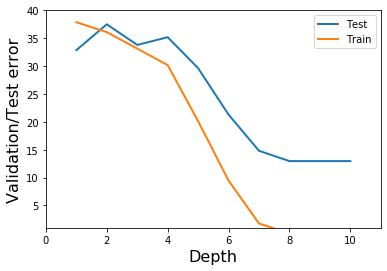

In [14]:
#MONK2

    # Load the training data
M = np.genfromtxt('monks_data/monks-2.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytrn = M[:, 0]
Xtrn = M[:, 1:]

# Load the test data
M = np.genfromtxt('monks_data/monks-2.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytst = M[:, 0]
Xtst = M[:, 1:]

plt.figure()
i=[1,2,3,4,5,6,7,8,9,10]
tst_err=[]
trn_err=[]
for depth in i:
    decision_tree = id3(Xtrn, ytrn, max_depth=depth)
    # Compute the test error
    y_pred_tst = [predict_example(x, decision_tree) for x in Xtst]
    tst_err.append(compute_error(ytst, y_pred_tst)*100)
    y_pred_trn = [predict_example(x, decision_tree) for x in Xtrn]
    trn_err.append(compute_error(ytrn, y_pred_trn)*100)

plt.plot(i, tst_err, marker='None', linewidth=2)
plt.plot(i, trn_err, marker='None', linewidth=2)

plt.xlabel('Depth', fontsize=16)
plt.ylabel('Validation/Test error', fontsize=16)
plt.axis([0,11, 1, 40])
plt.legend(['Test'] + ['Train'])

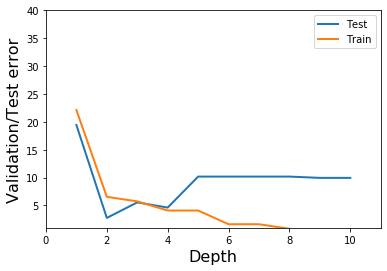

In [15]:
#MONK3

    # Load the training data
M = np.genfromtxt('monks_data/monks-3.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytrn = M[:, 0]
Xtrn = M[:, 1:]

# Load the test data
M = np.genfromtxt('monks_data/monks-3.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytst = M[:, 0]
Xtst = M[:, 1:]

plt.figure()
i=[1,2,3,4,5,6,7,8,9,10]
tst_err=[]
trn_err=[]
for depth in i:
    decision_tree = id3(Xtrn, ytrn, max_depth=depth)
    # Compute the test error
    y_pred_tst = [predict_example(x, decision_tree) for x in Xtst]
    tst_err.append(compute_error(ytst, y_pred_tst)*100)
    y_pred_trn = [predict_example(x, decision_tree) for x in Xtrn]
    trn_err.append(compute_error(ytrn, y_pred_trn)*100)

plt.plot(i, tst_err, marker='None', linewidth=2)
plt.plot(i, trn_err, marker='None', linewidth=2)

plt.xlabel('Depth', fontsize=16)
plt.ylabel('Validation/Test error', fontsize=16)
plt.axis([0,11, 1, 40])
plt.legend(['Test'] + ['Train'])

# Part c.

In [16]:
from sklearn.metrics import confusion_matrix
import pandas as pd

#MONK1
    # Load the training data
M = np.genfromtxt('monks_data/monks-1.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytrn = M[:, 0]
Xtrn = M[:, 1:]

# Load the test data
M = np.genfromtxt('monks_data/monks-1.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytst = M[:, 0]
Xtst = M[:, 1:]

decision_tree = id3(Xtrn, ytrn, max_depth=1)
# Compute the test error
y_pred_tst = [predict_example(x, decision_tree) for x in Xtst]

# Visualize the tree and save it as a PNG image
dot_str = to_graphviz(decision_tree)
render_dot_file(dot_str, './my_learned_tree_depth1')

pd.DataFrame(
    confusion_matrix(ytst, y_pred_tst),
    columns=['Positive', 'Negative'],
    index=['Positive', 'Negative']
)


,Positive,Negative
Positive,216,0
Negative,108,108


In [17]:
decision_tree = id3(Xtrn, ytrn, max_depth=3)
# Compute the test error
y_pred_tst = [predict_example(x, decision_tree) for x in Xtst]

# Visualize the tree and save it as a PNG image
dot_str = to_graphviz(decision_tree)
render_dot_file(dot_str, './my_learned_tree_depth3')

pd.DataFrame(
    confusion_matrix(ytst, y_pred_tst),
    columns=['Positive', 'Negative'],
    index=['Positive', 'Negative']
)


,Positive,Negative
Positive,144,72
Negative,0,216


In [18]:
decision_tree = id3(Xtrn, ytrn, max_depth=5)
# Compute the test error
y_pred_tst = [predict_example(x, decision_tree) for x in Xtst]

# Visualize the tree and save it as a PNG image
dot_str = to_graphviz(decision_tree)
render_dot_file(dot_str, './my_learned_tree5')

pd.DataFrame(
    confusion_matrix(ytst, y_pred_tst),
    columns=['Positive', 'Negative'],
    index=['Positive', 'Negative']
)


,Positive,Negative
Positive,156,60
Negative,12,204


# Part d.

In [19]:
from sklearn import tree

M = np.genfromtxt('monks_data/monks-1.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytrn = M[:, 0]
Xtrn = M[:, 1:]

    # Load the test data
M = np.genfromtxt('monks_data/monks-1.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytst = M[:, 0]
Xtst = M[:, 1:]

model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=1)
model = model.fit(Xtrn, ytrn)
y_predict = model.predict(Xtst)

pd.DataFrame(
    confusion_matrix(ytst, y_predict),
    columns=['Positive', 'Negative'],
    index=['Positive', 'Negative']
)

,Positive,Negative
Positive,216,0
Negative,108,108


In [20]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
model = model.fit(Xtrn, ytrn)
y_predict = model.predict(Xtst)

pd.DataFrame(
    confusion_matrix(ytst, y_predict),
    columns=['Positive', 'Negative'],
    index=['Positive', 'Negative']
)

,Positive,Negative
Positive,144,72
Negative,0,216


In [21]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
model = model.fit(Xtrn, ytrn)
y_predict = model.predict(Xtst)

pd.DataFrame(
    confusion_matrix(ytst, y_predict),
    columns=['Positive', 'Negative'],
    index=['Positive', 'Negative']
)

,Positive,Negative
Positive,168,48
Negative,24,192


# Part e.

## Part c.

In [22]:
from sklearn import model_selection

M = np.genfromtxt('caesarian.csv', missing_values=0, skip_header=0, delimiter=',', dtype=int)
Y = M[:, 5]
X = M[:, 1:4]
validation_size = 0.30
seed = 7
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

decision_tree = id3(X_train, Y_train, max_depth=1)
# Compute the test error
y_pred_tst = [predict_example(x, decision_tree) for x in X_test]

# Visualize the tree and save it as a PNG image
dot_str = to_graphviz(decision_tree)
render_dot_file(dot_str, './my_learned_caesarian_tree_depth1')

pd.DataFrame(
    confusion_matrix(Y_test, y_pred_tst),
    columns=['Positive', 'Negative'],
    index=['Positive', 'Negative']
)

,Positive,Negative
Positive,8,5
Negative,4,7


In [23]:
decision_tree = id3(X_train, Y_train, max_depth=3)
# Compute the test error
y_pred_tst = [predict_example(x, decision_tree) for x in X_test]

# Visualize the tree and save it as a PNG image
dot_str = to_graphviz(decision_tree)
render_dot_file(dot_str, './my_learned_caesarian_tree_depth3')

pd.DataFrame(
    confusion_matrix(Y_test, y_pred_tst),
    columns=['Positive', 'Negative'],
    index=['Positive', 'Negative']
)

,Positive,Negative
Positive,8,5
Negative,3,8


In [24]:
decision_tree = id3(X_train, Y_train, max_depth=5)
# Compute the test error
y_pred_tst = [predict_example(x, decision_tree) for x in X_test]

# Visualize the tree and save it as a PNG image
dot_str = to_graphviz(decision_tree)
render_dot_file(dot_str, './my_learned_caesarian_tree_depth5')


pd.DataFrame(
    confusion_matrix(Y_test, y_pred_tst),
    columns=['Positive', 'Negative'],
    index=['Positive', 'Negative']
)

,Positive,Negative
Positive,6,7
Negative,5,6


## Part d.

In [25]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=1)
model = model.fit(X_train, Y_train)
y_predict = model.predict(X_test)

pd.DataFrame(
    confusion_matrix(Y_test, y_predict),
    columns=['Positive', 'Negative'],
    index=['Positive', 'Negative']
)

,Positive,Negative
Positive,0,13
Negative,0,11


In [26]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
model = model.fit(X_train, Y_train)
y_predict = model.predict(X_test)

pd.DataFrame(
    confusion_matrix(Y_test, y_predict),
    columns=['Positive', 'Negative'],
    index=['Positive', 'Negative']
)

,Positive,Negative
Positive,9,4
Negative,6,5


In [27]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
model = model.fit(X_train, Y_train)
y_predict = model.predict(X_test)

pd.DataFrame(
    confusion_matrix(Y_test, y_predict),
    columns=['Positive', 'Negative'],
    index=['Positive', 'Negative']
)

,Positive,Negative
Positive,9,4
Negative,5,6
